In [17]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

In [3]:
pos = pd.read_excel("enriched_fire_data_1000_rows.xlsx")
neg = pd.read_excel("negative dataset.xlsx")

In [12]:
pos = pos[["ELEVATION", "SLOPE", "LANDCOVER", "T2M", "RH2M", "WS2M", "ssm(m³/m³)", "fire"]]
neg = neg[["ELEVATION", "SLOPE", "LANDCOVER", "T2M", "RH2M", "WS2M", "ssm(m³/m³)", "fire"]]

In [13]:
pos.head()

,ELEVATION,SLOPE,LANDCOVER,T2M,RH2M,WS2M,ssm(m³/m³),fire
0,2997,42.94040,Forest,-5.73,35.90,1.45,0.151760,1
1,2680,31.30040,Grassland,11.73,37.04,1.85,0.015875,1
2,195,1.44966,Forest,24.31,16.16,1.78,0.019480,1
3,1571,22.54260,Grassland,15.89,34.04,1.68,0.068128,1
4,842,30.54230,Forest,19.32,41.44,3.00,0.046613,1


/tmp/ipython-input-3719149188.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(pos, x='ELEVATION', y='LANDCOVER', inner='box', palette='Dark2')


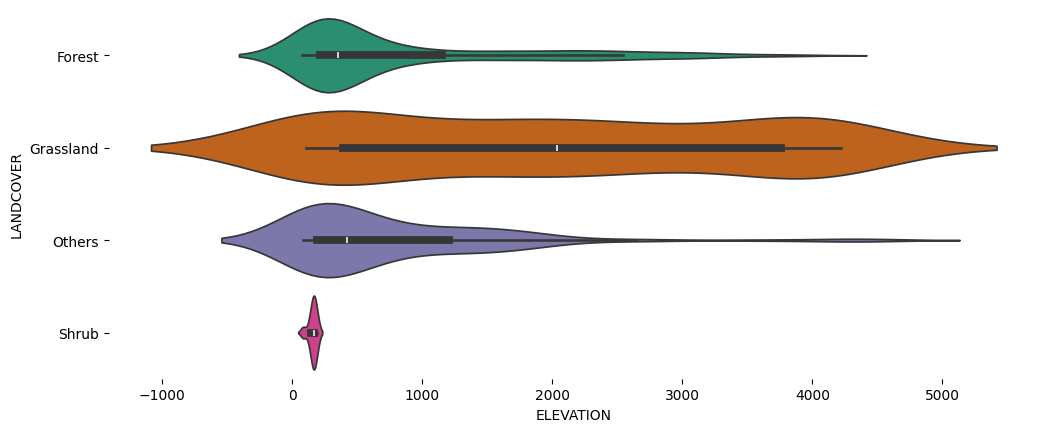

In [9]:
# @title LANDCOVER vs ELEVATION

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(pos['LANDCOVER'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(pos, x='ELEVATION', y='LANDCOVER', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [14]:
neg.head()

,ELEVATION,SLOPE,LANDCOVER,T2M,RH2M,WS2M,ssm(m³/m³),fire
0,3009.654022,41.973425,Forest,-4.322192,38.309519,1.334752,0.217464,0
1,2695.734127,30.804050,Grassland,12.090385,41.946390,1.740683,0.030321,0
2,204.986899,0.622035,Forest,24.223606,21.214051,1.939129,0.083775,0
3,1556.575023,20.827868,Grassland,13.502312,40.457891,1.546018,0.113453,0
4,845.445776,28.264443,Forest,18.263447,42.339425,2.653434,0.110762,0


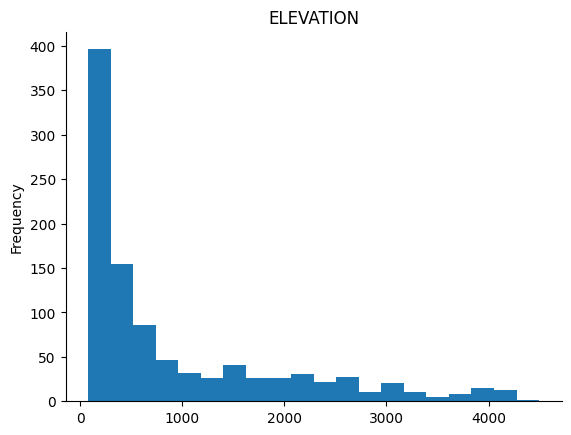

In [8]:
# @title ELEVATION

from matplotlib import pyplot as plt
neg['ELEVATION'].plot(kind='hist', bins=20, title='ELEVATION')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
df = pd.concat([pos, neg.iloc[1:, :]], ignore_index=True)
df.head()

,ELEVATION,SLOPE,LANDCOVER,T2M,RH2M,WS2M,ssm(m³/m³),fire
0,2997.0,42.94040,Forest,-5.73,35.90,1.45,0.151760,1
1,2680.0,31.30040,Grassland,11.73,37.04,1.85,0.015875,1
2,195.0,1.44966,Forest,24.31,16.16,1.78,0.019480,1
3,1571.0,22.54260,Grassland,15.89,34.04,1.68,0.068128,1
4,842.0,30.54230,Forest,19.32,41.44,3.00,0.046613,1


In [16]:
df.LANDCOVER.unique()

array(['Forest', 'Grassland', 'Others', 'Shrub'], dtype=object)

In [18]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
landcover_encoded = ohe.fit_transform(df[['LANDCOVER']])

feature_names = ohe.get_feature_names_out(['LANDCOVER'])
landcover_encoded_df = pd.DataFrame(landcover_encoded, columns=feature_names, index=df.index)

df_encoded_ohe = df.drop('LANDCOVER', axis=1).reset_index(drop=True)
df_encoded_ohe = pd.concat([df_encoded_ohe, landcover_encoded_df], axis=1)

display(df_encoded_ohe.head())

,ELEVATION,SLOPE,T2M,RH2M,WS2M,ssm(m³/m³),fire,LANDCOVER_Forest,LANDCOVER_Grassland,LANDCOVER_Others,LANDCOVER_Shrub
0,2997.0,42.94040,-5.73,35.90,1.45,0.151760,1,1.0,0.0,0.0,0.0
1,2680.0,31.30040,11.73,37.04,1.85,0.015875,1,0.0,1.0,0.0,0.0
2,195.0,1.44966,24.31,16.16,1.78,0.019480,1,1.0,0.0,0.0,0.0
3,1571.0,22.54260,15.89,34.04,1.68,0.068128,1,0.0,1.0,0.0,0.0
4,842.0,30.54230,19.32,41.44,3.00,0.046613,1,1.0,0.0,0.0,0.0


In [19]:
y = df_encoded_ohe['fire']
X = df_encoded_ohe.drop('fire', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    label_encoder=False,
)

In [54]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:56:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, label_encoder=False,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [55]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.945


In [56]:
y_pred_train = model.predict(X_train)
print("Accuracy:", accuracy_score(y_pred_train, y_train))

Accuracy: 1.0


In [57]:
import joblib

joblib.dump(model, 'xgboost_model.pkl')
joblib.dump(ohe, 'onehot_encoder.pkl')

print("Model and encoder saved successfully.")

Model and encoder saved successfully.
